In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (classification_report, roc_auc_score, 
                            confusion_matrix, accuracy_score, 
                            precision_score, recall_score, f1_score,
                            roc_curve, auc)
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif

In [2]:
# Plot Styling
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load Dataset
train = pd.read_csv('application_train.csv')
test = pd.read_csv('application_test.csv')


=== Preprocessing Summary ===
Final features used: 17
Numerical features: ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'REGION_RATING_CLIENT', 'AGE', 'EMPLOYMENT_YEARS']
Categorical features: ['CODE_GENDER', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE']
Training data shape: (307511, 19)
Test data shape: (48744, 83)


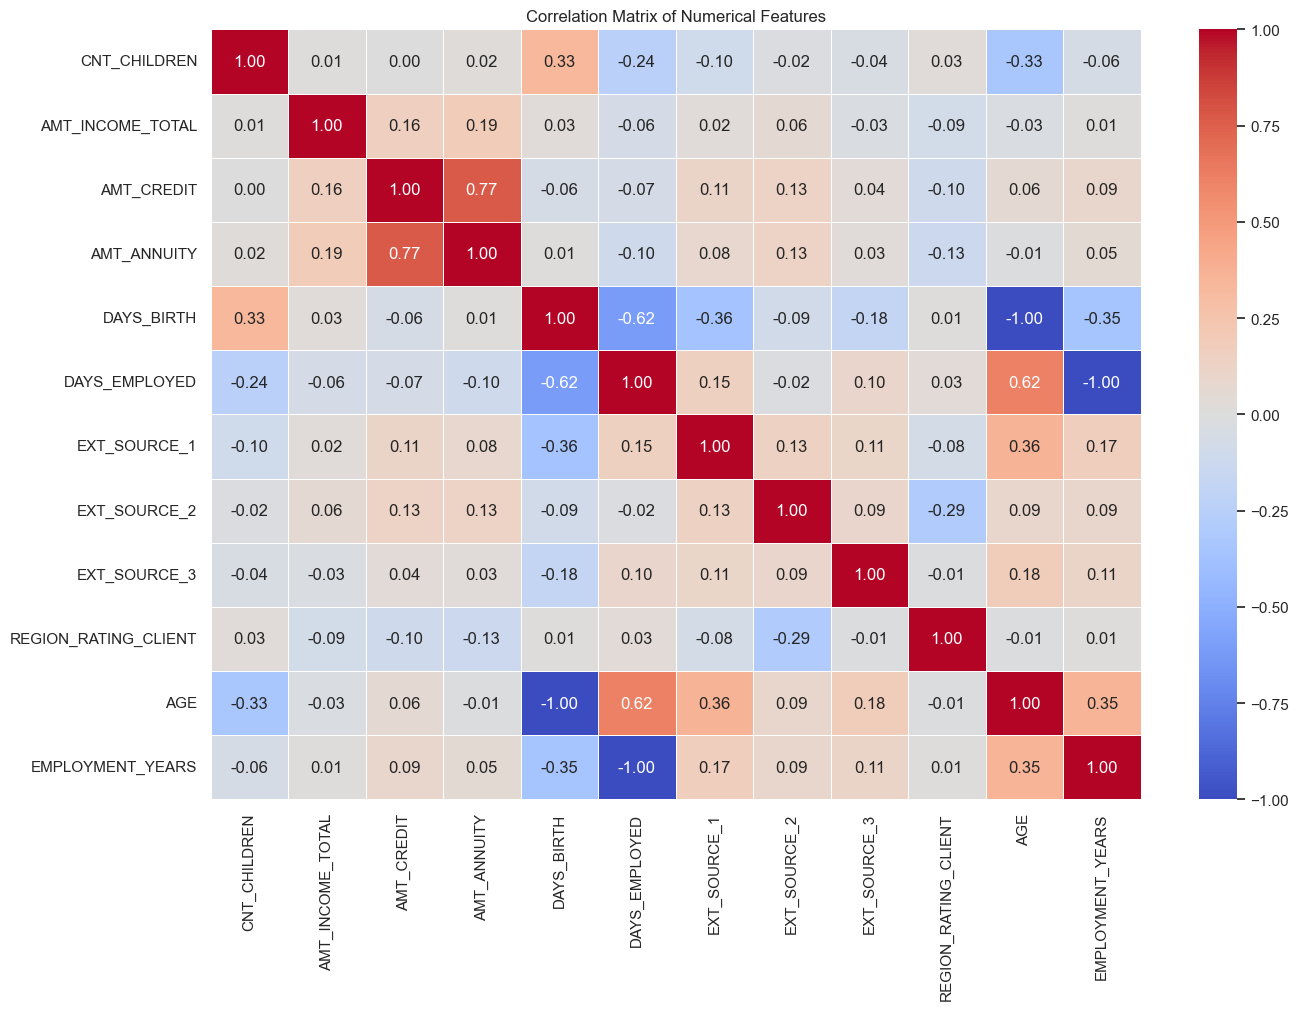

In [3]:
# 1. Preprocessing

# verify the target column
if 'TARGET' not in train.columns:
    raise ValueError("Target column 'TARGET' not found in training data")

# Handle missing values & protect critical columns
protected_features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
                    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'AMT_CREDIT']

threshold = len(train) * 0.5
cols_to_drop = [col for col in train.columns 
               if (train[col].isna().sum() > threshold) 
               and (col not in protected_features)
               and (col != 'TARGET')]
train = train.drop(columns=cols_to_drop)

# Align test data with train columns
missing_cols = set(train.columns) - set(test.columns) - {'TARGET'}
if missing_cols:
    print(f"Adding {len(missing_cols)} missing columns to test data")
    for col in missing_cols:
        test[col] = np.nan  # Fill with NA

# Ensure same columns in test data (excluding target)
test = test[train.columns.drop('TARGET')]

# Define features with existence check
features = [
    'CODE_GENDER', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
    'AMT_ANNUITY', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'EXT_SOURCE_1', 'EXT_SOURCE_2',
    'EXT_SOURCE_3', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_HOUSING_TYPE',
    'OCCUPATION_TYPE', 'REGION_RATING_CLIENT'
]

# Verify feature existence
available_features = [f for f in features if f in train.columns]
missing_features = set(features) - set(available_features)

if missing_features:
    print(f"Warning: Missing features {missing_features} - they will be skipped")
    features = available_features

# Create feature sets
X = train[features].copy()  
y = train['TARGET']

# Feature engineering - add new features to X
# Convert days to years 
X['AGE'] = X['DAYS_BIRTH'] / -365
X['EMPLOYMENT_YEARS'] = X['DAYS_EMPLOYED'].replace(365243, np.nan) / -365

# Apply same transformations to test data
test['AGE'] = test['DAYS_BIRTH'] / -365
test['EMPLOYMENT_YEARS'] = test['DAYS_EMPLOYED'].replace(365243, np.nan) / -365

# Handle missing values in EXT_SOURCE columns
for source_col in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']:
    if source_col in X.columns:
        X[source_col] = X[source_col].fillna(X[source_col].median())
        test[source_col] = test[source_col].fillna(test[source_col].median())

# Identify numerical and categorical columns
# Update numerical_cols to include our new features
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()

# Create preprocessing pipelines
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

# Validation output
print("\n=== Preprocessing Summary ===")
print(f"Final features used: {len(features)}")
print(f"Numerical features: {numerical_cols}")
print(f"Categorical features: {categorical_cols}")
print(f"Training data shape: {X.shape}")
print(f"Test data shape: {test.shape}")

# For correlation matrix - use X instead of train
corr_matrix = X[numerical_cols].corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            center=0, linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

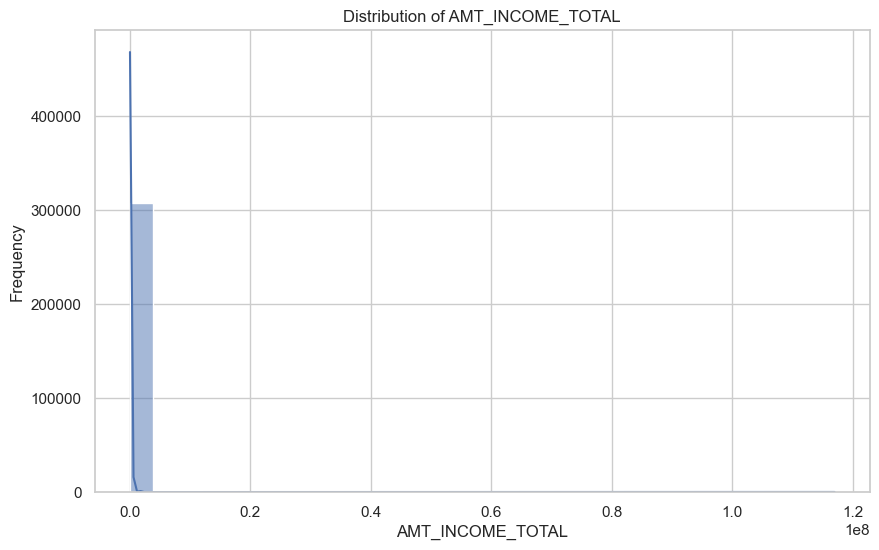

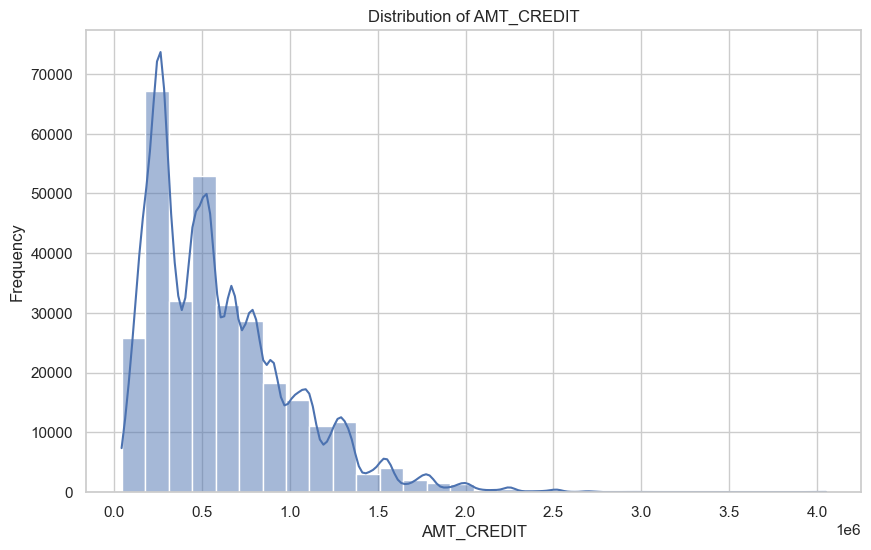

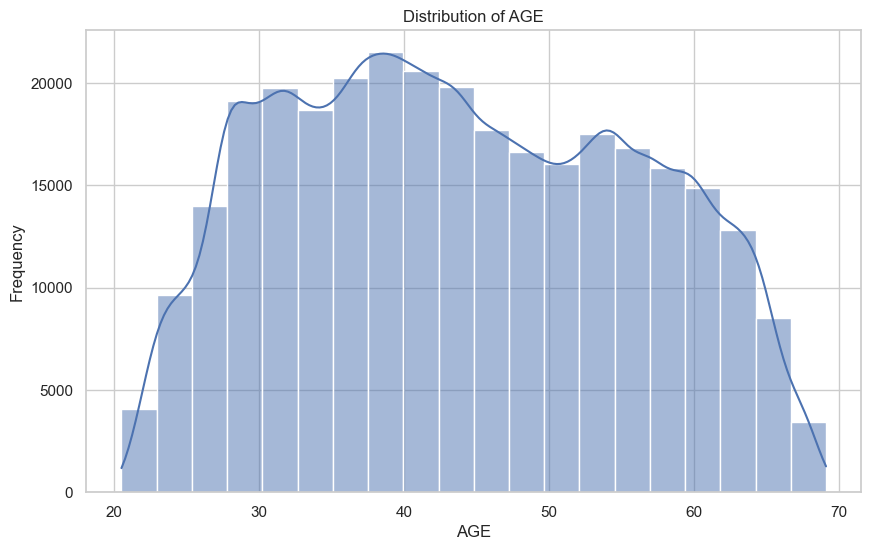

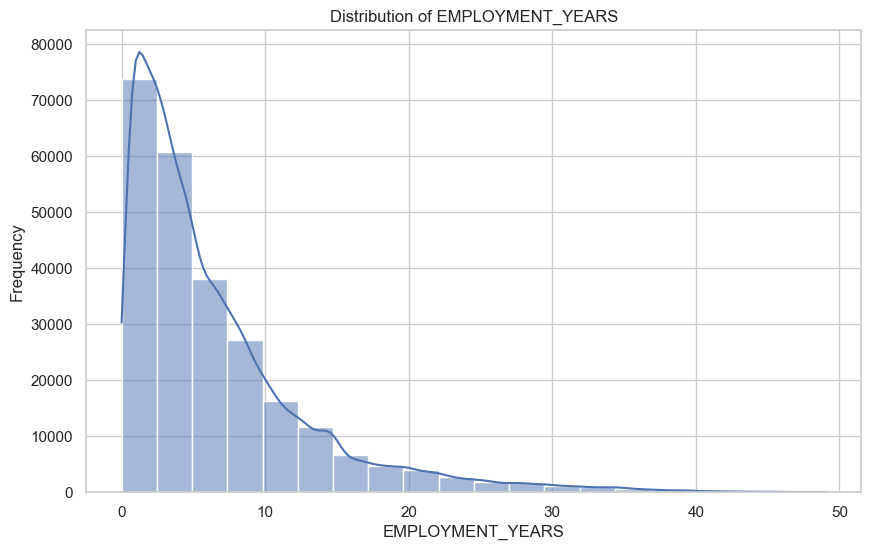

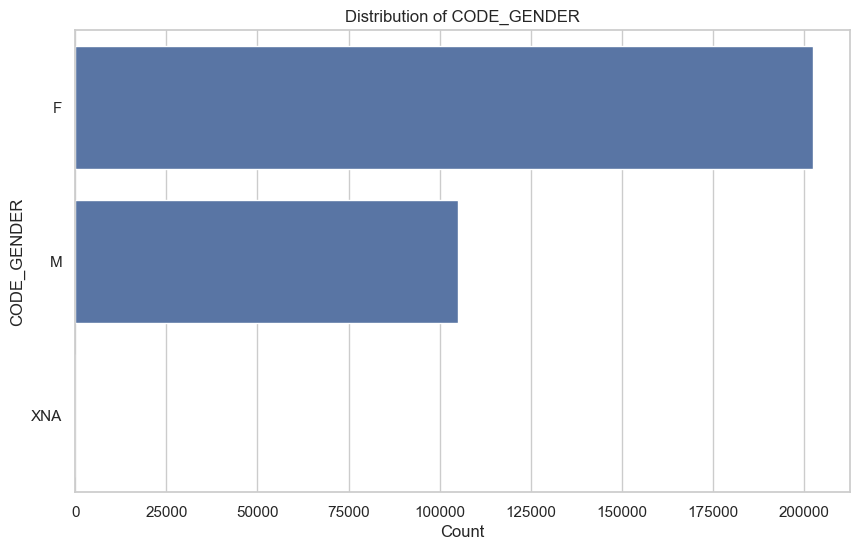

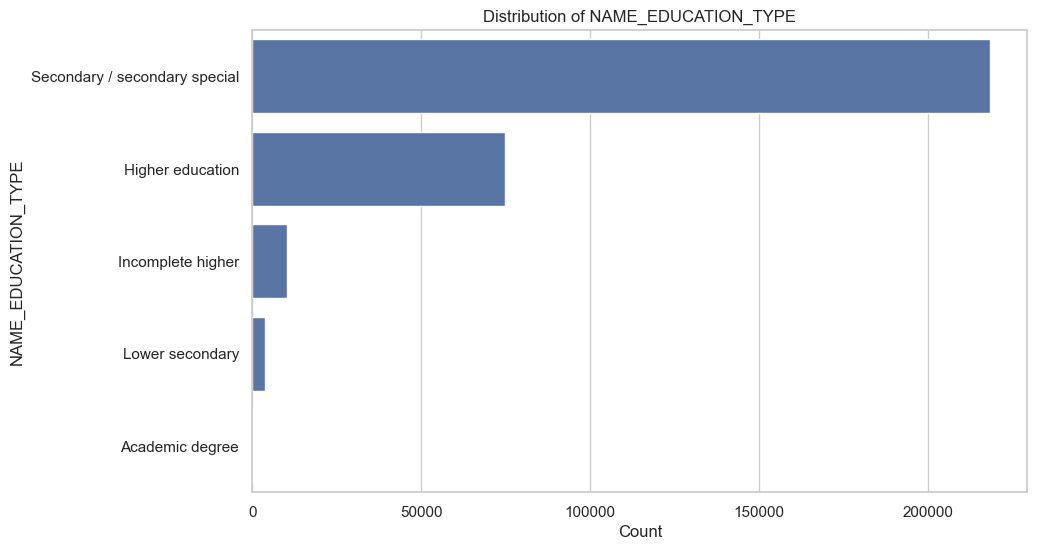

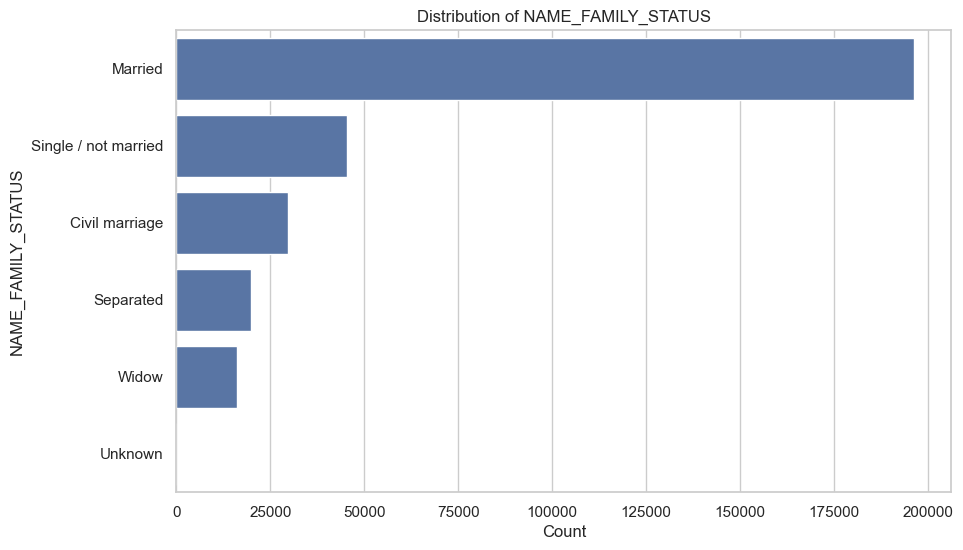

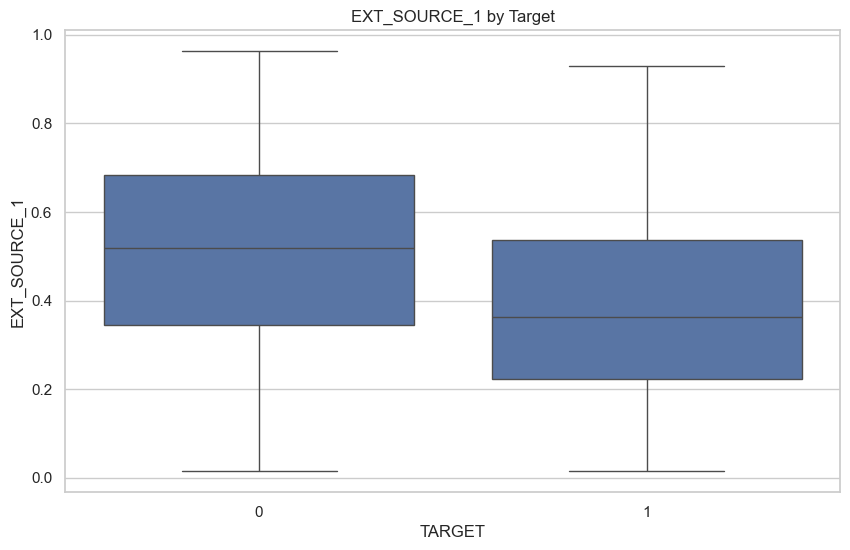

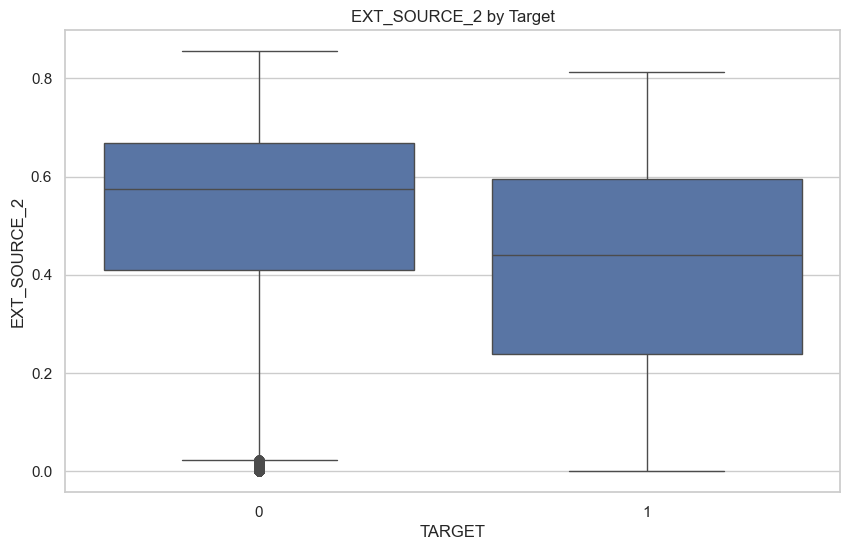

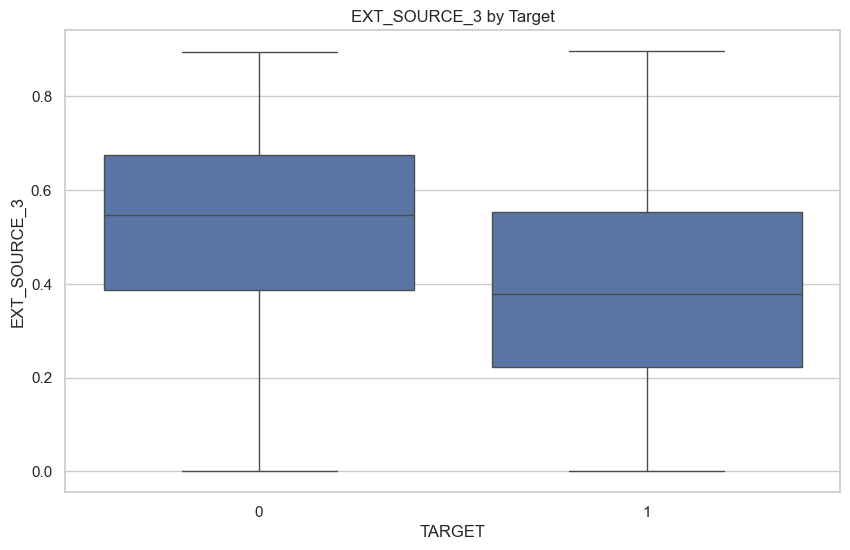

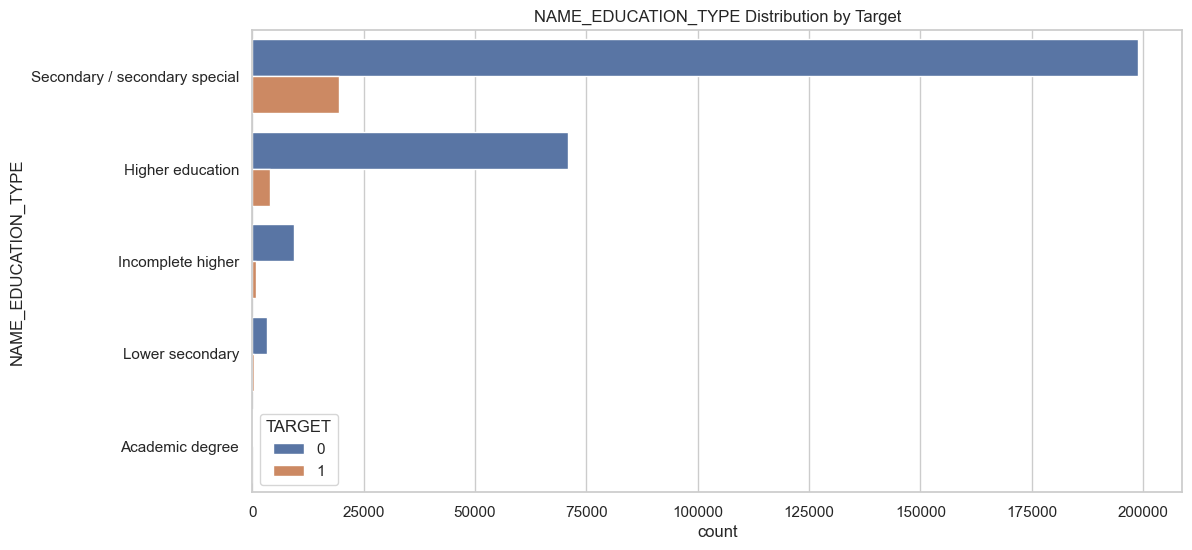

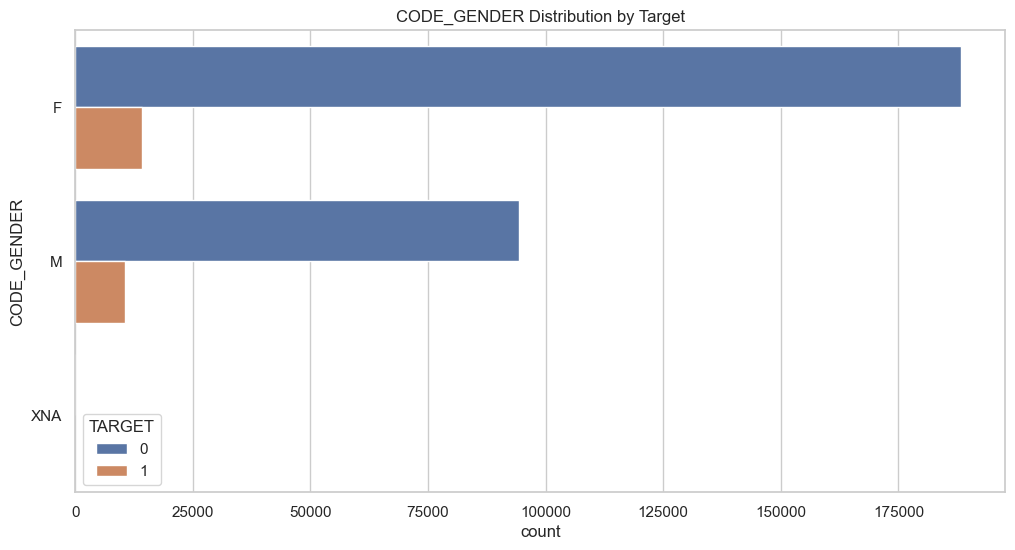

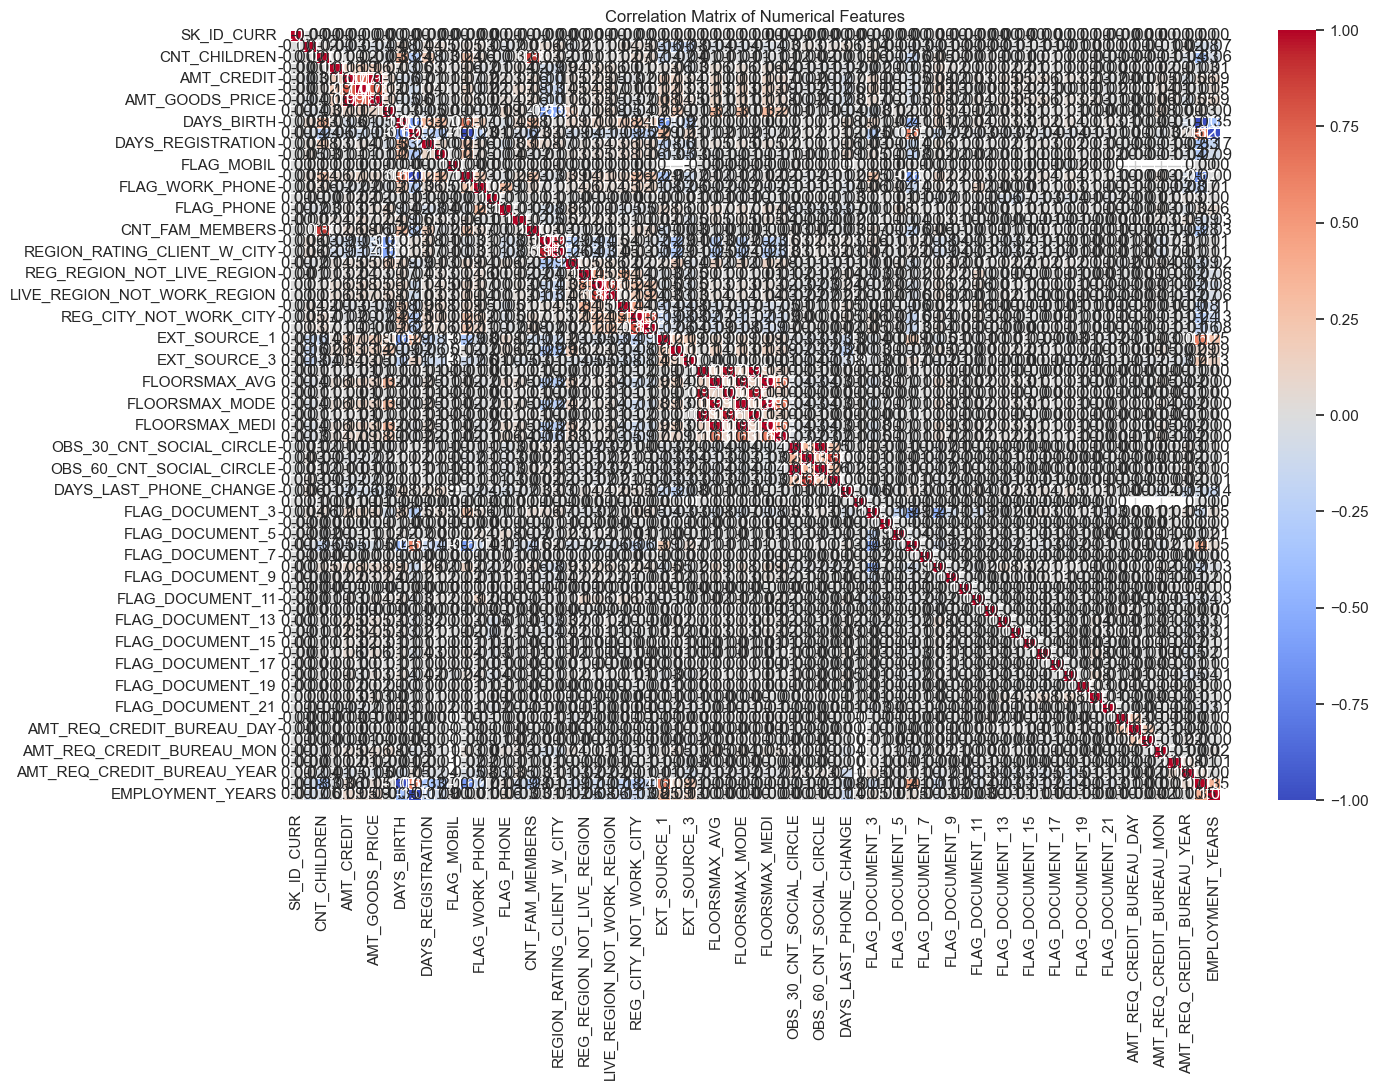

In [4]:
# 2. Exploratory Data Analysis (EDA)


# create a copy of train with our engineered features for EDA
eda_df = train.copy()
eda_df['AGE'] = eda_df['DAYS_BIRTH'] / -365
eda_df['EMPLOYMENT_YEARS'] = eda_df['DAYS_EMPLOYED'].replace(365243, np.nan) / -365

# Update numerical columns to include our new features
numerical_cols_eda = eda_df.select_dtypes(include=['int64', 'float64']).columns.tolist()

def plot_distribution(column, data=eda_df, bins=30):
    """Plot distribution of a numerical column"""
    plt.figure(figsize=(10, 6))
    sns.histplot(data[column], bins=bins, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

def plot_categorical(column, data=eda_df):
    """Plot count distribution of a categorical column"""
    plt.figure(figsize=(10, 6))
    sns.countplot(y=column, data=data, order=data[column].value_counts().index)
    plt.title(f'Distribution of {column}')
    plt.xlabel('Count')
    plt.ylabel(column)
    plt.show()

def plot_target_correlation(column, data=eda_df):
    """Plot correlation with target for numerical columns"""
    if data[column].dtype in ['int64', 'float64']:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='TARGET', y=column, data=data)
        plt.title(f'{column} by Target')
        plt.show()
    else:
        plt.figure(figsize=(12, 6))
        sns.countplot(y=column, hue='TARGET', data=data, 
                     order=data[column].value_counts().index)
        plt.title(f'{column} Distribution by Target')
        plt.show()

# Plot distributions of key features
plot_distribution('AMT_INCOME_TOTAL')
plot_distribution('AMT_CREDIT')
plot_distribution('AGE', bins=20)  # Using AGE instead of DAYS_BIRTH
plot_distribution('EMPLOYMENT_YEARS', bins=20)  # Using EMPLOYMENT_YEARS instead of DAYS_EMPLOYED

# Plot categorical distributions
plot_categorical('CODE_GENDER')
plot_categorical('NAME_EDUCATION_TYPE')
plot_categorical('NAME_FAMILY_STATUS')

# Plot correlations with target
plot_target_correlation('EXT_SOURCE_1')
plot_target_correlation('EXT_SOURCE_2')
plot_target_correlation('EXT_SOURCE_3')
plot_target_correlation('NAME_EDUCATION_TYPE')
plot_target_correlation('CODE_GENDER')

# Correlation matrix - using updated numerical columns
corr_matrix = eda_df[numerical_cols_eda].corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            center=0, linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [5]:
# 3. Model Training 

from xgboost import XGBClassifier

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, 
                                                 random_state=42, 
                                                 stratify=y)

# Define models to compare
models = {
    "Logistic Regression": LogisticRegression(random_state=42, 
                                           class_weight='balanced',
                                           max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=42, 
                                         class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42, 
                             scale_pos_weight=(y == 0).sum() / (y == 1).sum(),
                             use_label_encoder=False,
                             eval_metric='logloss'),
    "K-Nearest Neighbors": KNeighborsClassifier()
}



=== Model Evaluation ===

Training and evaluating Logistic Regression...
Accuracy: 0.6851
Precision: 0.1571
Recall: 0.6642
F1 Score: 0.2541
ROC AUC: 0.7374

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.69      0.80     56538
           1       0.16      0.66      0.25      4965

    accuracy                           0.69     61503
   macro avg       0.56      0.68      0.53     61503
weighted avg       0.89      0.69      0.76     61503



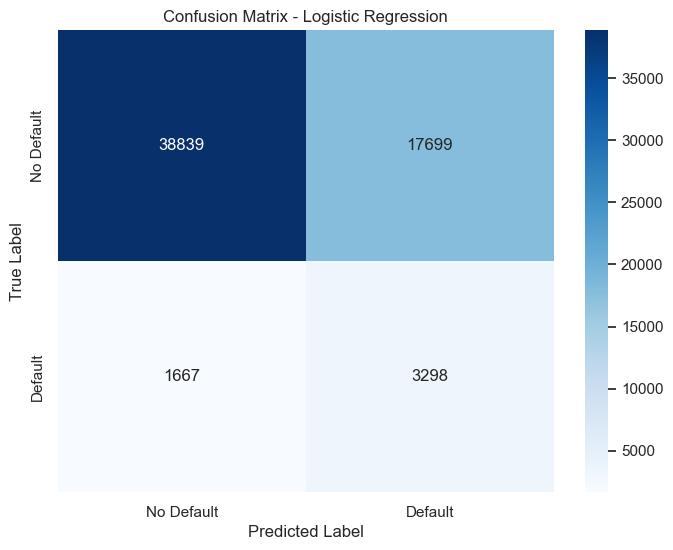


Training and evaluating Random Forest...
Accuracy: 0.9194
Precision: 0.6000
Recall: 0.0054
F1 Score: 0.0108
ROC AUC: 0.7230

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.60      0.01      0.01      4965

    accuracy                           0.92     61503
   macro avg       0.76      0.50      0.48     61503
weighted avg       0.89      0.92      0.88     61503



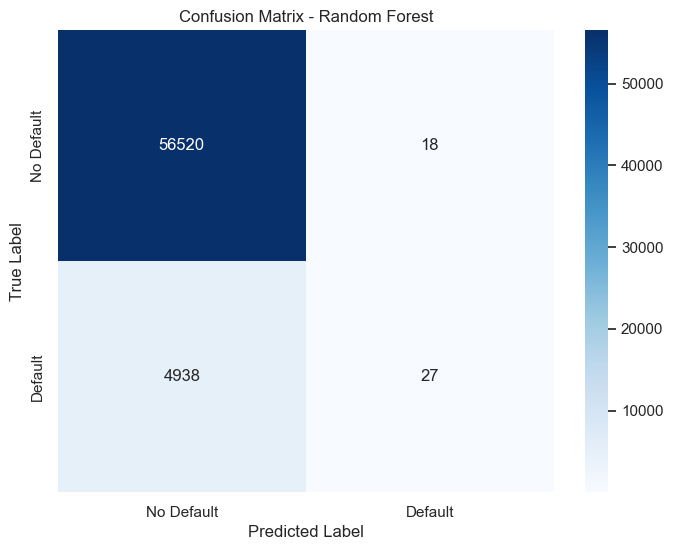


Training and evaluating Gradient Boosting...
Accuracy: 0.9195
Precision: 0.5729
Recall: 0.0111
F1 Score: 0.0217
ROC AUC: 0.7476

Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.57      0.01      0.02      4965

    accuracy                           0.92     61503
   macro avg       0.75      0.51      0.49     61503
weighted avg       0.89      0.92      0.88     61503



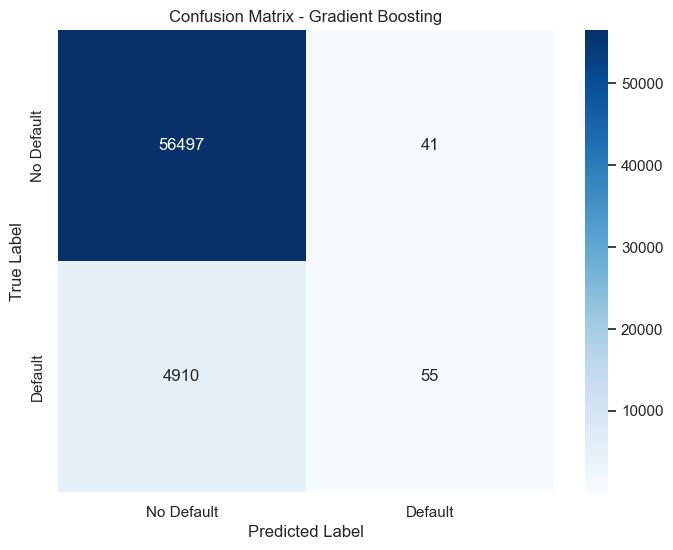


Training and evaluating XGBoost...


c:\VSCode\Python\Lib\site-packages\xgboost\training.py:183: UserWarning: [04:22:48] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.7166
Precision: 0.1669
Recall: 0.6290
F1 Score: 0.2638
ROC AUC: 0.7404

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.72      0.82     56538
           1       0.17      0.63      0.26      4965

    accuracy                           0.72     61503
   macro avg       0.56      0.68      0.54     61503
weighted avg       0.89      0.72      0.78     61503



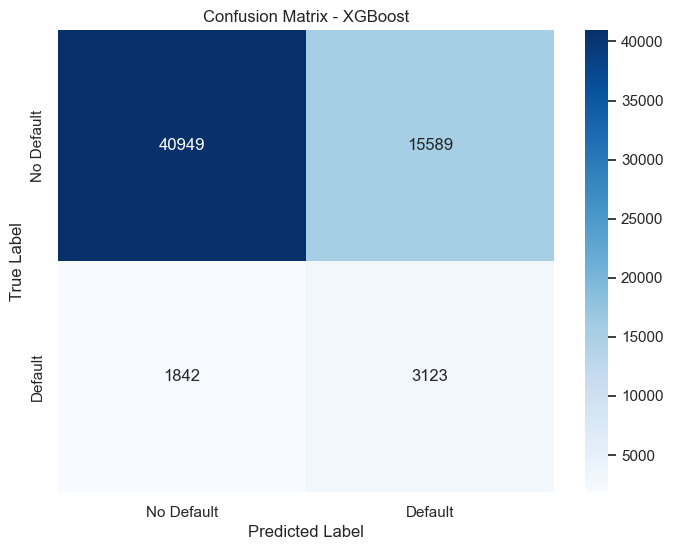


Training and evaluating K-Nearest Neighbors...
Accuracy: 0.9126
Precision: 0.2521
Recall: 0.0421
F1 Score: 0.0721
ROC AUC: 0.6039

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     56538
           1       0.25      0.04      0.07      4965

    accuracy                           0.91     61503
   macro avg       0.59      0.52      0.51     61503
weighted avg       0.87      0.91      0.88     61503



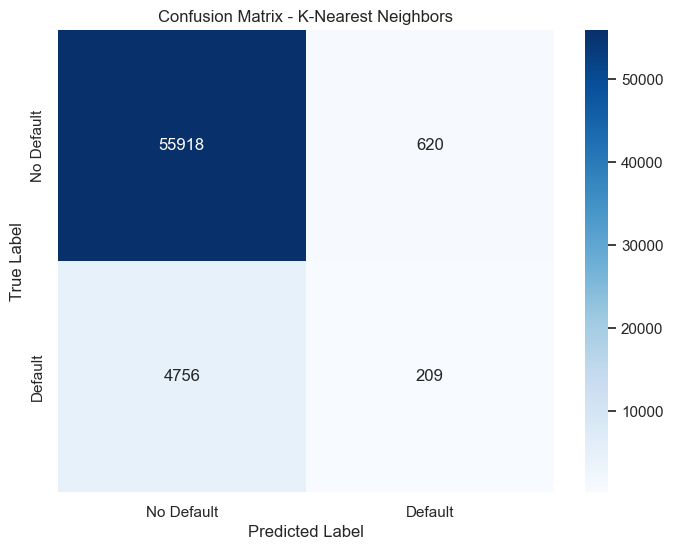

In [6]:
# 4. Model Evaluation

# Create dictionaries to store results
model_pipelines = {}
model_scores = {}
model_predictions = {}
model_probabilities = {}

print("\n=== Model Evaluation ===")

# Train and evaluate each model
for name, model in models.items():
    print(f"\nTraining and evaluating {name}...")
    
    # Create the full pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    
    # Store the pipeline
    model_pipelines[name] = pipeline
    
    # Fit the model
    pipeline.fit(X_train, y_train)
    
    # Get predictions
    y_pred = pipeline.predict(X_val)
    model_predictions[name] = y_pred
    
    # Get prediction probabilities for ROC curve (if the model supports it)
    try:
        y_proba = pipeline.predict_proba(X_val)[:, 1]
        model_probabilities[name] = y_proba
    except:
        print(f"Warning: {name} does not support predict_proba. ROC curve won't be available.")
        model_probabilities[name] = None
    
    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    
    # Calculate ROC AUC (if probabilities are available)
    if model_probabilities[name] is not None:
        roc_auc = roc_auc_score(y_val, model_probabilities[name])
    else:
        roc_auc = None
    
    # Store scores
    model_scores[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc
    }
    
    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    if roc_auc:
        print(f"ROC AUC: {roc_auc:.4f}")
    
    # Print detailed classification report
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))
    
    # Print confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Default', 'Default'],
                yticklabels=['No Default', 'Default'])
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()



=== Model Comparison ===
                     Accuracy  Precision    Recall  F1 Score   ROC AUC
Logistic Regression  0.685121   0.157070  0.664250  0.254064  0.737384
Random Forest        0.919419   0.600000  0.005438  0.010778  0.722973
Gradient Boosting    0.919500   0.572917  0.011078  0.021735  0.747564
XGBoost              0.716583   0.166898  0.629003  0.263800  0.740446
K-Nearest Neighbors  0.912590   0.252111  0.042095  0.072144  0.603925


<Figure size 1400x800 with 0 Axes>

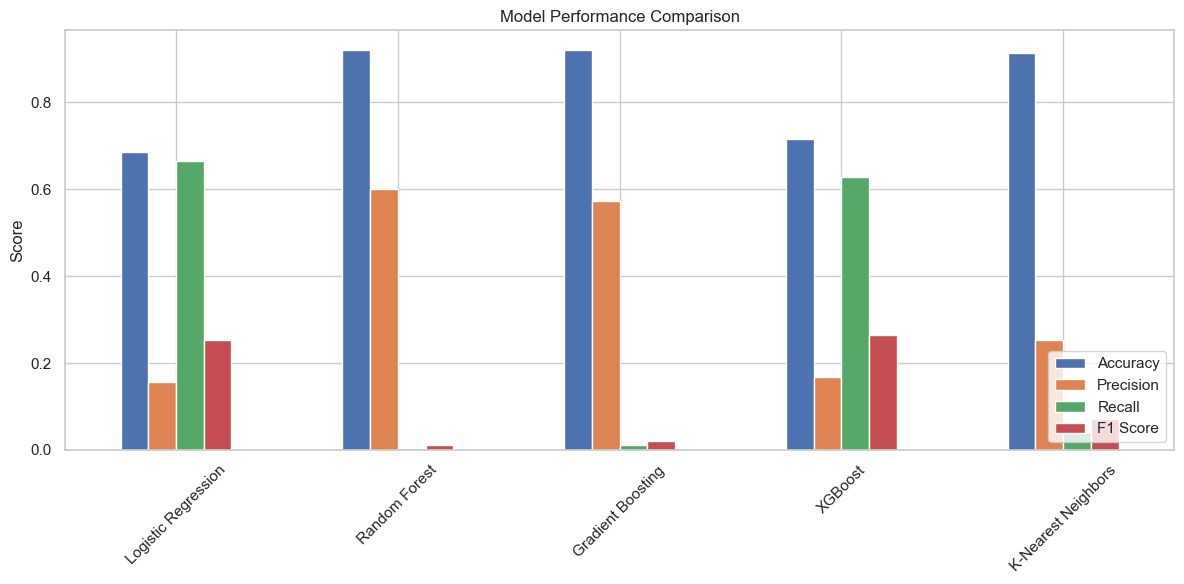

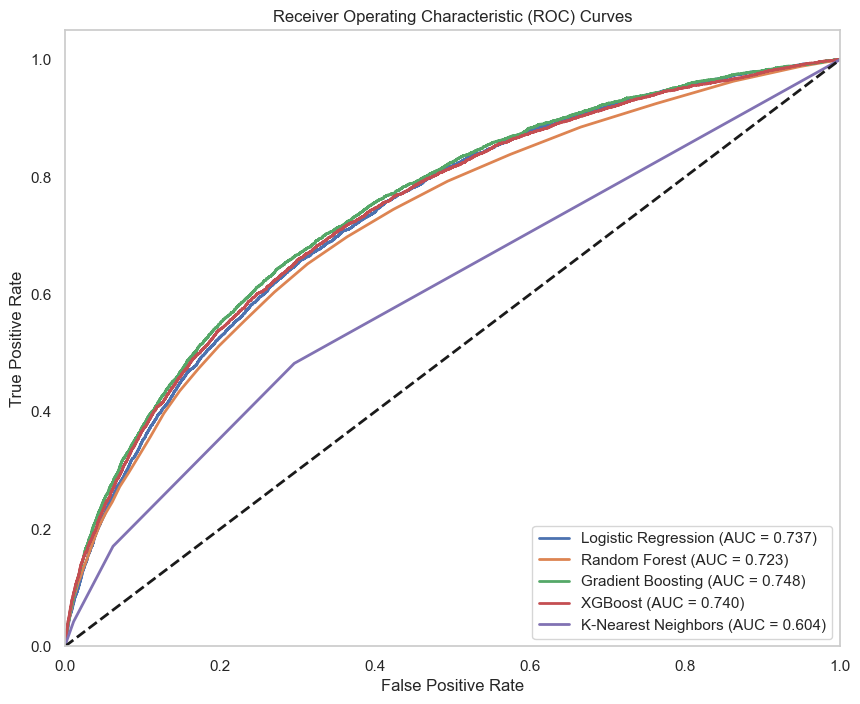

In [7]:
# 5. Membandingkan Model

# Create a DataFrame to compare model performances
compare_df = pd.DataFrame({
    'Accuracy': [scores['accuracy'] for scores in model_scores.values()],
    'Precision': [scores['precision'] for scores in model_scores.values()],
    'Recall': [scores['recall'] for scores in model_scores.values()],
    'F1 Score': [scores['f1'] for scores in model_scores.values()],
    'ROC AUC': [scores['roc_auc'] for scores in model_scores.values()]
}, index=model_scores.keys())

print("\n=== Model Comparison ===")
print(compare_df)

# Plot comparison metrics
plt.figure(figsize=(14, 8))
compare_df[['Accuracy', 'Precision', 'Recall', 'F1 Score']].plot(kind='bar')
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xticks(rotation=45)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

# Plot ROC curves for all models
plt.figure(figsize=(10, 8))
for name, proba in model_probabilities.items():
    if proba is not None:
        fpr, tpr, _ = roc_curve(y_val, proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.grid()
plt.show()


=== Making predictions on test data ===

=== Sample of prediction results ===
   SK_ID_CURR  PREDICTION  DEFAULT_PROBABILITY LOAN_STATUS
0      100001           0                 0.03    Approved
1      100005           0                 0.08    Approved
2      100013           0                 0.00    Approved
3      100028           0                 0.03    Approved
4      100038           0                 0.06    Approved

=== Results saved to loan_predictions.csv ===

=== Prediction Summary ===
Total applications: 48744
Approved applications: 48102 (98.68%)
Rejected applications: 642 (1.32%)


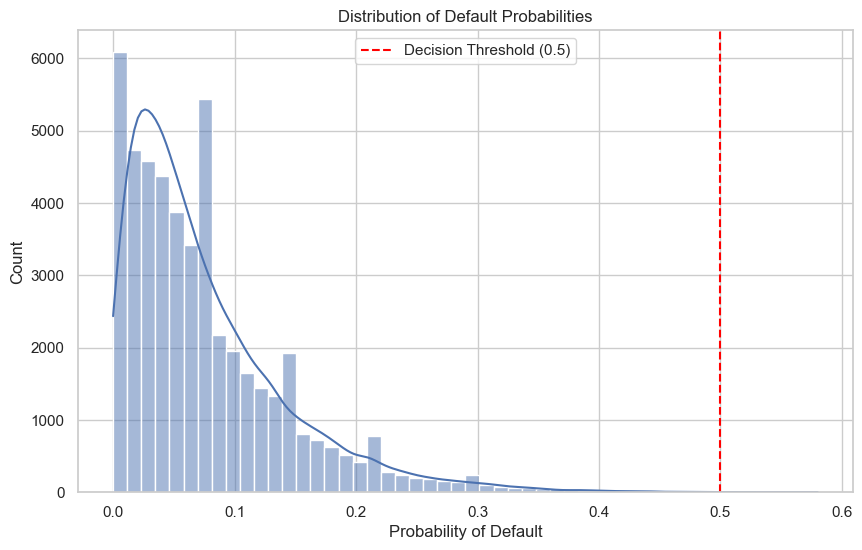

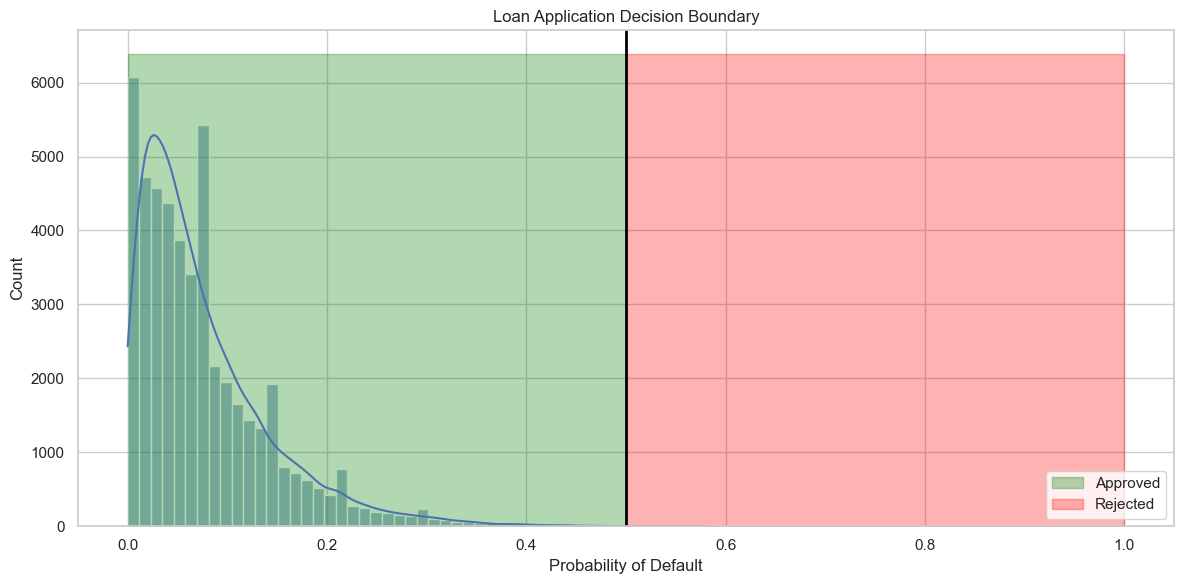

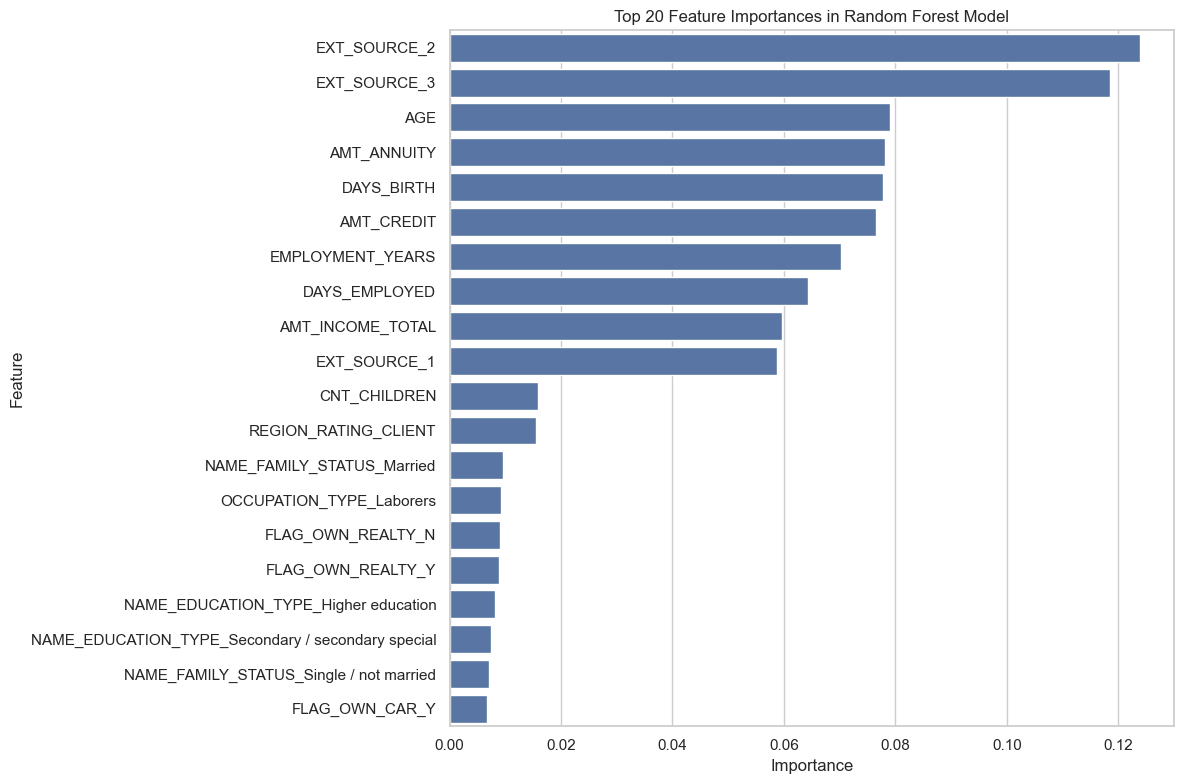

In [8]:
# Get the best performing model (Random Forest)
best_model = model_pipelines["Random Forest"]

# Make predictions on the test data
print("\n=== Making predictions on test data ===")
test_probabilities = best_model.predict_proba(test)[:, 1]

# Apply 0.3 threshold for approval decision
# If probability < 0.3: Approved (0)
# If probability >= 0.3: Rejected (1)
test_predictions = (test_probabilities >= 0.3).astype(int)

# Create a DataFrame for the results
results_df = pd.DataFrame({
    'SK_ID_CURR': test['SK_ID_CURR'],
    'PREDICTION': test_predictions,
    'DEFAULT_PROBABILITY': test_probabilities
})

# Add a more descriptive label
results_df['LOAN_STATUS'] = results_df['PREDICTION'].apply(
    lambda x: 'Rejected (Default Risk)' if x == 1 else 'Approved'
)

# Display the first few results
print("\n=== Sample of prediction results ===")
print(results_df.head())

# Save the results to a CSV file
output_filename = 'loan_predictions.csv'
results_df.to_csv(output_filename, index=False)
print(f"\n=== Results saved to {output_filename} ===")

# Generate a summary of the results
approval_rate = (results_df['PREDICTION'] == 0).mean() * 100
rejection_rate = (results_df['PREDICTION'] == 1).mean() * 100

print(f"\n=== Prediction Summary ===")
print(f"Total applications: {len(results_df)}")
print(f"Approved applications: {(results_df['PREDICTION'] == 0).sum()} ({approval_rate:.2f}%)")
print(f"Rejected applications: {(results_df['PREDICTION'] == 1).sum()} ({rejection_rate:.2f}%)")

# Create a visualization of the predictions with the threshold
plt.figure(figsize=(10, 6))
sns.histplot(results_df['DEFAULT_PROBABILITY'], bins=50, kde=True)
plt.axvline(0.5, color='red', linestyle='--', label='Decision Threshold (0.5)')
plt.title('Distribution of Default Probabilities')
plt.xlabel('Probability of Default')
plt.ylabel('Count')
plt.legend()
plt.show()

# Add a visualization to clearly show the approved vs rejected regions
plt.figure(figsize=(12, 6))
ax = sns.histplot(results_df['DEFAULT_PROBABILITY'], bins=50, kde=True)
plt.axvline(0.5, color='black', linestyle='-', linewidth=2)

# Add shaded regions
max_height = ax.get_ylim()[1]
plt.fill_between([0, 0.5], [0, 0], [max_height, max_height], color='green', alpha=0.3, label='Approved')
plt.fill_between([0.5, 1], [0, 0], [max_height, max_height], color='red', alpha=0.3, label='Rejected')

plt.title('Loan Application Decision Boundary')
plt.xlabel('Probability of Default')
plt.ylabel('Count')
plt.legend()
plt.tight_layout()
plt.show()

# Optional: Show feature importances from the Random Forest model
if hasattr(best_model['classifier'], 'feature_importances_'):
    # Get feature names after preprocessing
    feature_names = []
    for name, transformer, cols in best_model['preprocessor'].transformers_:
        if hasattr(transformer, 'get_feature_names_out'):
            feature_names.extend(transformer.get_feature_names_out(cols))
        else:
            feature_names.extend(cols)
    
    # Get feature importances
    importances = best_model['classifier'].feature_importances_
    
    # Create DataFrame with feature importances
    if len(importances) == len(feature_names):
        feature_imp = pd.DataFrame({
            'Feature': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)
        
        # Plot top 20 feature importances
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Importance', y='Feature', data=feature_imp.head(20))
        plt.title('Top 20 Feature Importances in Random Forest Model')
        plt.tight_layout()
        plt.show()
    else:
        print("Warning: Feature names and importances don't match in length.")